In [5]:
import pandas as pd

문제 1
======
## 데이터

In [6]:
D=pd.read_excel("http://data.hossam.kr/E06/temperatures_seoul.xlsx",index_col="날짜")

In [7]:
data=pd.DataFrame(D)

### 데이터 확인

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 18299 entries, 1973-07-01 to 2023-08-06
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   평균기온(℃)  18299 non-null  float64
dtypes: float64(1)
memory usage: 285.9 KB


In [9]:
data.head(2)

,평균기온(℃)
날짜,
1973-07-01,22.7
1973-07-02,23.8


### Step1. 데이터 시각화 및 주기성 확인

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.tsa.arima as sta
import statsmodels.graphics.tsaplots as sgt
import statsmodels.tsa.seasonal as sts
import seaborn as sb

In [11]:
plt.rcParams["figure.figsize"]=(10,5)
plt.rcParams["font.family"]="BM YEONSUNG"
plt.rcParams["axes.unicode_minus"]=False

#### 전체 데이터 시각화
> 정상성을 확인

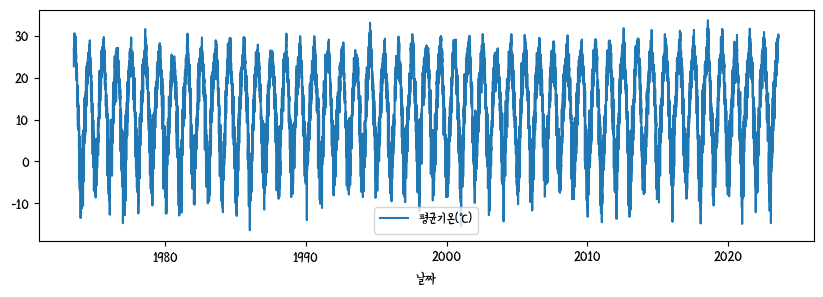

In [12]:
# 전체
plt.figure(figsize=(10,3))
sb.lineplot(data)
plt.show()
plt.close()

In [13]:
import statsmodels.tsa.stattools as stst

### ADF 검정
> 다음 데이터는 정상성을 만족

In [14]:
stst.adfuller(data,regression="c",autolag="BIC")[1]

3.5131992192343327e-25

#### Question
> 년단위에 존재하는 추세는 어떻게 제거할 것인가?

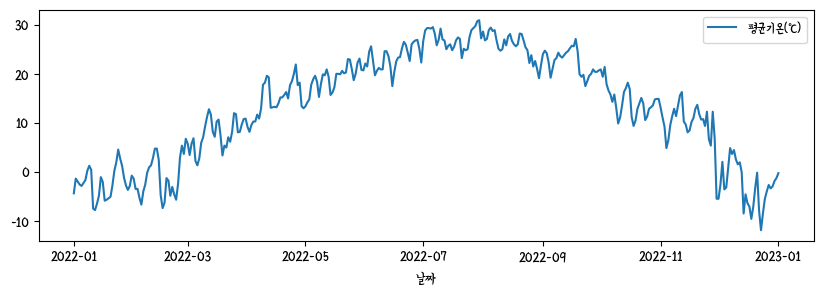

In [15]:
# 2022년만 보자
idx=(data.index>=pd.to_datetime("2022.1.1"))&(data.index<=pd.to_datetime("2023.1.1"))
plt.figure(figsize=(10,3))
sb.lineplot(data[idx])
plt.show()
plt.close()

#### 이상치
> 이상치는 없다. 또한 있더라도 실제 기온을 측정한 값이므로 제거하지 않겠음

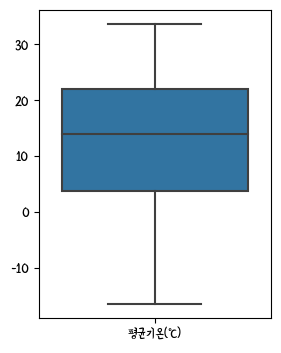

In [16]:
plt.figure(figsize=(3,4))
sb.boxplot(data)
plt.show()
plt.close()

### Step 1.5 ACF,PCAF
> d=0, q=0 ,p=4

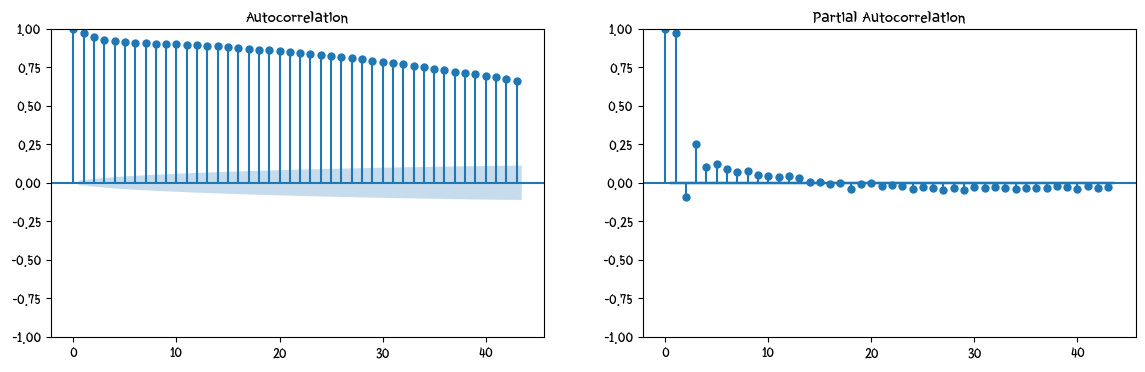

In [17]:
plt.rcParams["figure.figsize"]=(14,4)
f,a=plt.subplots(1,2)
sgt.plot_acf(data,ax=a[0])
sgt.plot_pacf(data,ax=a[1])
plt.show()

In [18]:
pd.DataFrame(sgt.pacf(data[data.columns[0]]))

,0
0,1.000000
1,0.974662
2,-0.094955
3,0.252189
4,0.100500
5,0.123621
6,0.089317
7,0.073426
8,0.074534
9,0.051155


In [19]:
df1=data.diff()
df1.dropna(inplace=True)

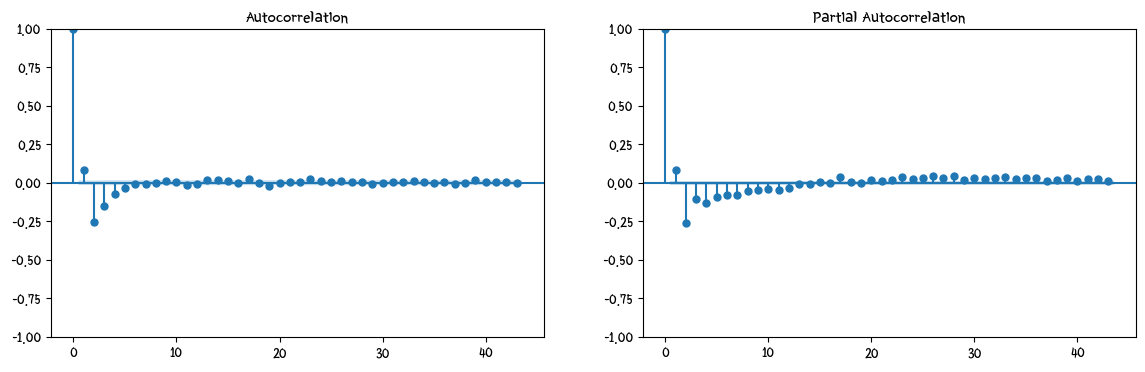

In [20]:
plt.rcParams["figure.figsize"]=(14,4)
f,a=plt.subplots(1,2)
sgt.plot_acf(df1,ax=a[0])
sgt.plot_pacf(df1,ax=a[1])
plt.show()

### Step2. 주기성 확인
> 문제 확인 : 데이터 양이 너무 많아 주기성 관찰이 어렵다

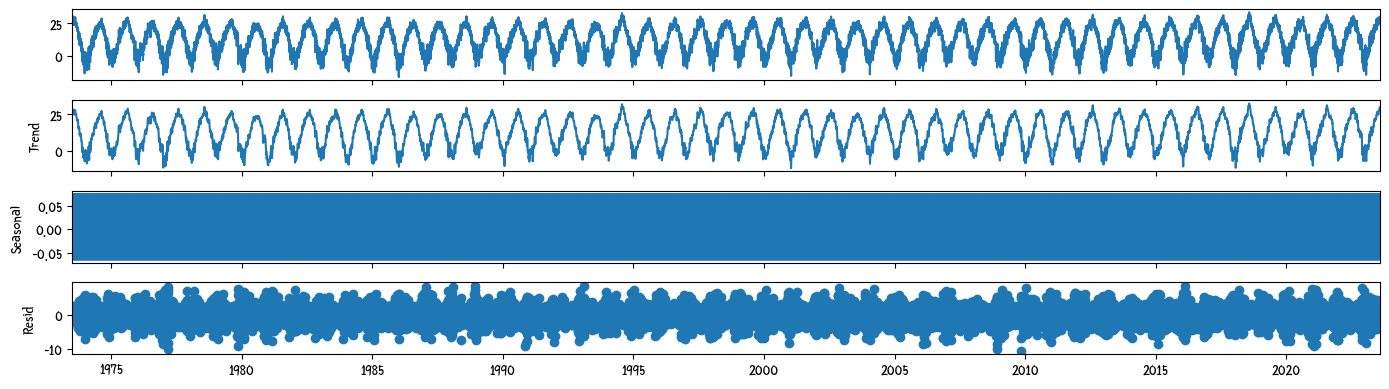

In [21]:
result=sts.seasonal_decompose(data)
result.plot()
plt.show()

In [22]:
for x in ["trend","seasonal",'resid']:
    data[x]=eval(f"result.{x}")

## Step3. 모델

In [23]:
# ㅎㅎ
import tqdm
import itertools

In [24]:
# 학습모델
import statsmodels.tsa.arima.model as arima

#### Step 3.5
> train, test data 분리

In [25]:
import datetime as dt

In [26]:
# 기준
add=dt.timedelta(days=365)
temp=pd.to_datetime("2023-8-6")

In [27]:
test_index=pd.date_range(start=temp-add,end=temp,freq="1d")
train_index=data.index.difference(test_index)

In [28]:
## 지은씌 잘봐...넌 boolean series..
idx=data.index<temp-add
Train=data.loc[idx]

In [29]:
Test=data.loc[test_index] # 검정
Train=data.loc[train_index] # 학습

In [30]:
Train=Train.asfreq(freq="1d")
Test=Test.asfreq(freq="1d")

#### grid search

In [31]:
#p,d,q=(4,0,0)
p,d,q=range(5),range(1),range(1)
pdq=list(itertools.product(p,d,q))

In [32]:
Train.drop(Train.columns[1:],inplace=True,axis=1)

In [33]:
params_aic={}
with tqdm.tqdm(total=len(pdq)) as pd:
    for i in pdq:
        pd.update(1)
        try:
            model=arima.ARIMA(Train,order=i)
            model_fit=model.fit()
            params_aic[(i)]=round(model_fit.aic,2)
            #aic.append(round(model_fit.aic,2))
            #params.append((i))
        except:
            continue

  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 5/5 [00:06<00:00,  1.31s/it]


In [34]:
best_order=[x for x,y in params_aic.items() if y==min(params_aic.values())][0]

#### AIC가 가장 작은 (4,0,0)을 기준으로 모델학습을 시키겠다

In [35]:
import pandas as pd

In [36]:
model=arima.ARIMA(Train,order=best_order)
fit=model.fit()

In [37]:
test_range=pd.date_range(start=pd.to_datetime("2021.8.5"),end=pd.to_datetime("2022.8.5"),freq="1d")

전체 데이터에 대한 학습도

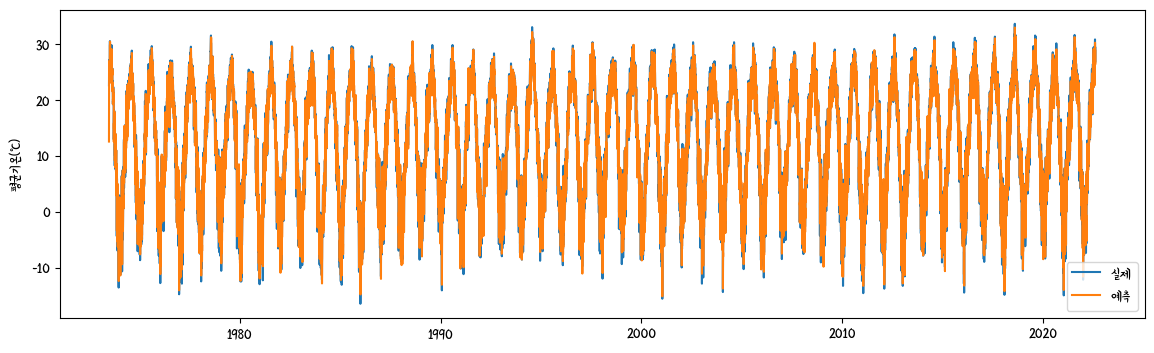

In [38]:
plt.figure()
sb.lineplot(Train[Train.columns[0]],label="실제")
sb.lineplot(fit.fittedvalues,label="예측")
plt.show()

부분적으로 학습이 잘 이루어졌나 시각화

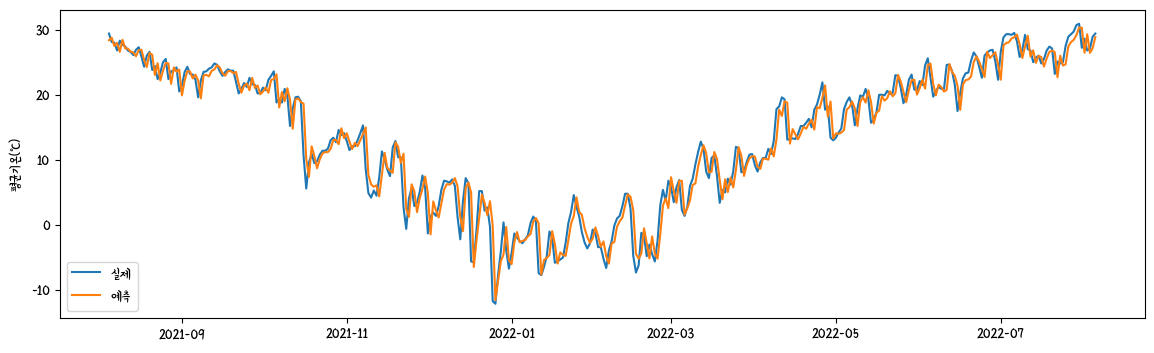

In [39]:
plt.figure()
sb.lineplot(Train.loc[test_range,Train.columns[0]],label="실제")
sb.lineplot(fit.fittedvalues[test_range],label="예측")
plt.show()

Test 데이터와 예측값을 비교해보기

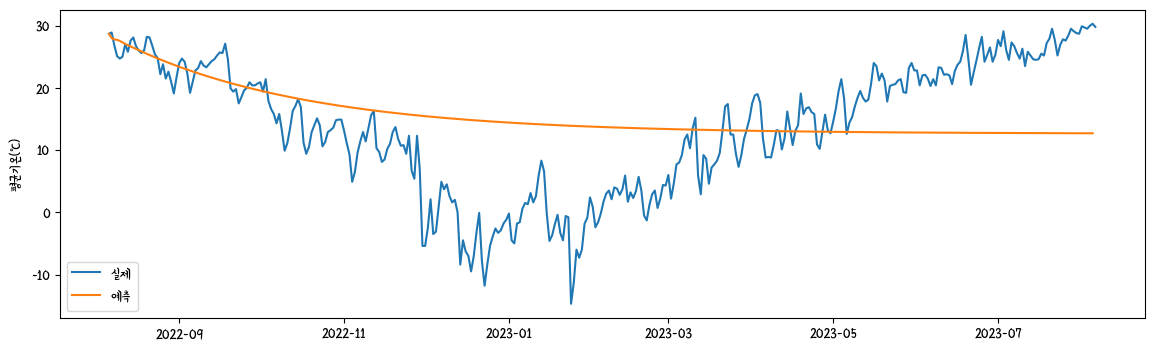

In [40]:
plt.figure()
sb.lineplot(Test[Test.columns[0]],label="실제")
sb.lineplot(fit.forecast(steps=365),label="예측")
plt.show()

#### 결론 : 이 시계열 학습모델은 예측력이 떨어짐
> 따라서 seasonality를 고려해야함

### Grid search

In [41]:
# 2번 grid search
p,d,q=range(5),range(1),range(1)
season=range(120,121) # 달마다 데이터가 반복된다고 가정
pdq=list(itertools.product(p,d,q))
s_pdq=list(itertools.product(p,d,q,season))
season_params_aic={}
best_model,best_aic=None,None
with tqdm.tqdm(total=len(s_pdq)*len(pdq)) as pd:
    for i in range(len(pdq)):
        for j in range(len(s_pdq)):
            pd.update(1)
            try:
                model=arima.ARIMA(Train.head(365*3),order=pdq[i],seasonal_order=s_pdq[j])
                model_fit=model.fit()
                season_params_aic[f"{i},{j}"]=round(model_fit.aic,2)
                if not best_aic:
                    best_model=model_fit
                    best_aic=round(model_fit.aic,2)
                elif round(model_fit.aic,2)<best_aic:
                    best_model=model_fit
                    best_aic=round(model_fit.aic,2)
                else:
                    continue
            except:
                continue

 20%|██        | 5/25 [27:49<2:53:47, 521.40s/it]

In [ ]:
# a,b=[x for x,y in season_params_aic.items() if y==min(season_params_aic.values())][0].split(",")

#### 최적의 파라미터

In [ ]:
final_order=pdq[int(a)]
final_order

(4, 0, 0)

In [ ]:
final_s_order=s_pdq[int(b)]
final_s_order

(3, 0, 0, 12)

### 시계열 학습모델

In [ ]:
# best_model=arima.ARIMA(Train,order=final_order,seasonal_order=final_s_order)

In [ ]:
# fit_best=best_model.fit()

### 시각화

전체

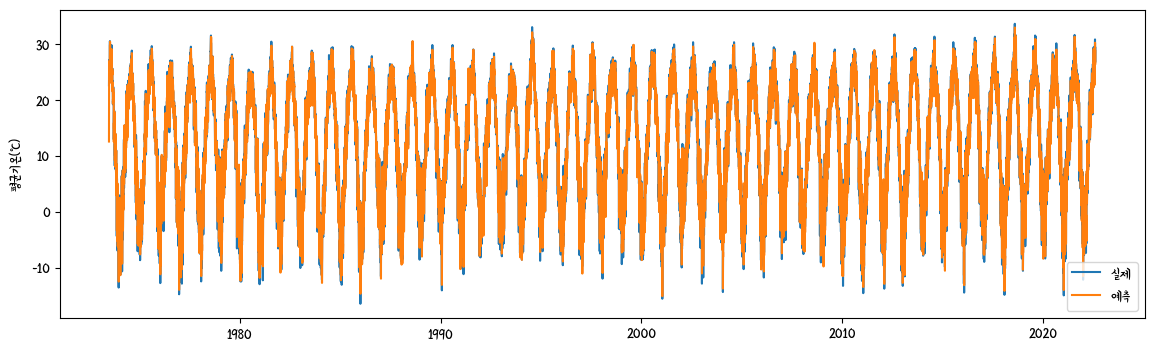

In [ ]:
plt.figure()
sb.lineplot(Train[Train.columns[0]],label="실제")
sb.lineplot(best_model.fittedvalues,label="예측")
plt.show()

부분적으로 학습이 잘 이루어졌나 시각화

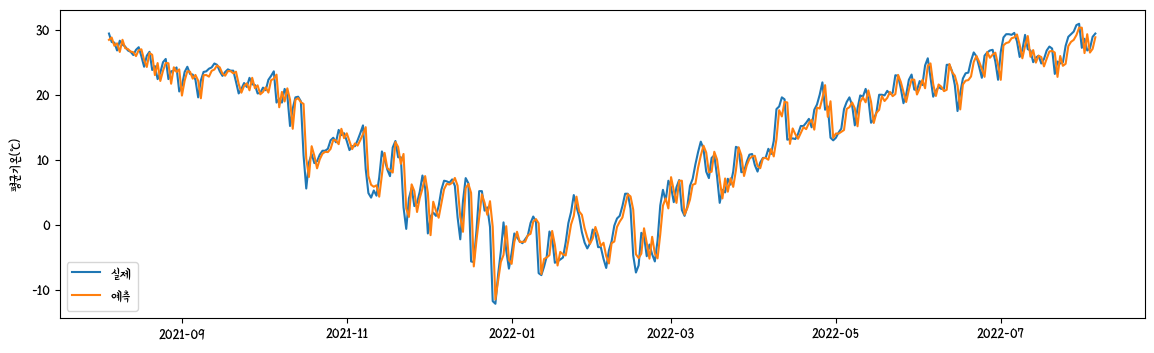

In [ ]:
plt.figure()
sb.lineplot(Train.loc[test_range,Train.columns[0]],label="실제")
sb.lineplot(best_model.fittedvalues[test_range],label="예측")
plt.show()

예측

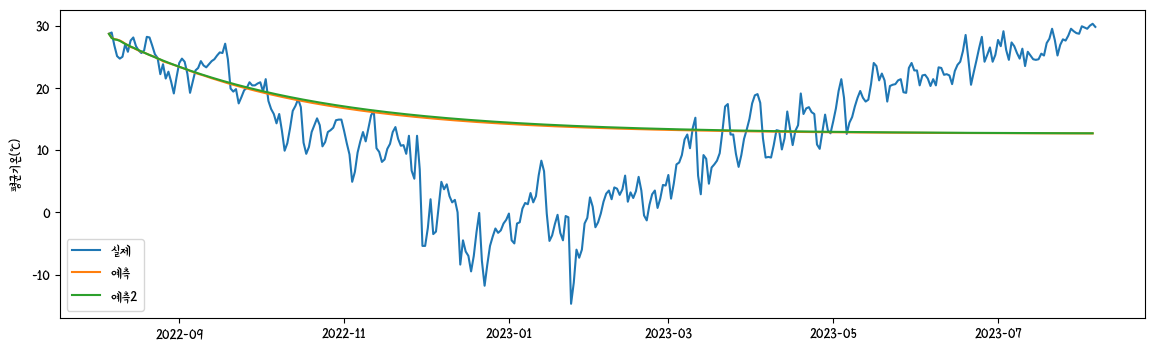

In [ ]:
plt.figure()
sb.lineplot(Test[Test.columns[0]],label="실제")
sb.lineplot(best_model.forecast(steps=365),label="예측")
sb.lineplot(fit.forecast(steps=365),label="예측2")
plt.show()

In [ ]:
best_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                    SARIMAX Results                                     
========================================================================================
Dep. Variable:                          평균기온(℃)   No. Observations:                17933
Model:             ARIMA(4, 0, 0)x(3, 0, 0, 12)   Log Likelihood              -39843.429
Date:                          Mon, 07 Aug 2023   AIC                          79704.859
Time:                                  20:44:22   BIC                          79775.008
Sample:                              07-01-1973   HQIC                         79727.931
                                   - 08-05-2022                                         
Covariance Type:                            opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         12.6292      1.018     12.408      0.000      10.634      14.624
ar.L1          1.0646      0.007    163.370      0.000       1.052       1.077
ar.L2         -0.3265      0.010    -32.567      0.000      -0.346      -0.307
ar.L3          0.1388      0.010     13.571      0.000       0.119       0.159
ar.L4          0.1031      0.007     15.528      0.000       0.090       0.116
ar.S.L12       0.0076      0.007      1.082      0.279      -0.006       0.021
ar.S.L24       0.0227      0.007      3.304      0.001       0.009       0.036
ar.S.L36       0.0159      0.007      2.264      0.024       0.002       0.030
sigma2         4.9804      0.040    124.636      0.000       4.902       5.059
===================================================================================
Ljung-Box (L1) (Q):                   3.00   Jarque-Bera (JB):              6250.86
Prob(Q):                              0.08   Prob(JB):                         0.00
Heteroskedasticity (H):               1.04   Skew:                            -0.89
Prob(H) (two-sided):                  0.17   Kurtosis:                         5.28
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""